In [3]:

from radiant_mlhub import Collection, Dataset

bbox = [28.529402, -1.753992, 30.328979, 1.359627]

re_dir = "./data/radiantEarth"

dataset = Dataset.fetch('ref_landcovernet_af_v1')
print(dataset.collections)
print(dataset.collections.source_imagery)
print(dataset.collections.labels)

collection_filter = dict(
    ref_landcovernet_af_v1_source_sentinel_2=['B02', 'B03', 'B04', 'B08'],
    ref_landcovernet_af_v1_labels=['labels', 'documentation']
)

# collection_filter still downloads catalogs for other collections - dumb
# dataset.download(collection_filter=collection_filter, output_dir="./data/radiantEarth/")

[<Collection id=ref_landcovernet_af_v1_source_sentinel_2>, <Collection id=ref_landcovernet_af_v1_source_sentinel_1>, <Collection id=ref_landcovernet_af_v1_source_landsat_8>, <Collection id=ref_landcovernet_af_v1_labels>]
[<Collection id=ref_landcovernet_af_v1_source_sentinel_2>, <Collection id=ref_landcovernet_af_v1_source_sentinel_1>, <Collection id=ref_landcovernet_af_v1_source_landsat_8>]
[<Collection id=ref_landcovernet_af_v1_labels>]


In [5]:
from radiant_mlhub import Collection
import tarfile


re_lc_dir = "./data/radiantEarth/landcover"

labels_collection = Collection.fetch('ref_landcovernet_af_v1_labels')
sentinel_collection = Collection.fetch('ref_landcovernet_af_v1_source_sentinel_2')

labels_archive = labels_collection.download(f'{re_dir}/labels')
sentinel_archive = sentinel_collection.download(f'{re_dir}/images')


In [ ]:
labels_tar = tarfile.open(labels_archive, "r:gz")
labels_tar.extractall()
labels_tar.close()

In [ ]:
sentinel_tar = tarfile.open(sentinel_archive, "r:gz")
sentinel_tar.extractall()
sentinel_tar.close()

In [ ]:
# would be cool to build a cloud cover model!
# https://mlhub.earth/data/ref_cloud_cover_detection_challenge_v1
# https://drivendata.co/blog/cloud-cover-benchmark/

# or https://www.azavea.com/blog/2021/08/02/the-azavea-cloud-dataset/

cloud_train_sentinel = Collection.fetch('ref_cloud_cover_detection_challenge_v1_train_source')
cloud_train_sentinel = labels_collection.download(f'{re_dir}/labels')

cloud_test_sentinel = Collection.fetch('ref_cloud_cover_detection_challenge_v1_test_source')

cloud_train_labels = Collection.fetch('ref_cloud_cover_detection_challenge_v1_train_labels')
cloud_test_labels = Collection.fetch('ref_cloud_cover_detection_challenge_v1_test_labels')


In [2]:
re_cloud_dir = "./data/radiantEarth/clouds/"
dataset = Dataset.fetch('ref_cloud_cover_detection_challenge_v1')
#dataset.download(output_dir=re_cloud_dir)

NameError: name 'Dataset' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import os
from osgeo import gdal
from pystac import ItemCollection
from pystac_client import Client
import rasterio
import requests
import shutil


from common.constants import NODATA_FLOAT32
from common.sagemaker_env import RADIANT_EARTH_API_KEY
import common.utilities.imagery as imagery



# Open a catalog
client = Client.open("https://api.radiant.earth/mlhub/v1", parameters={"key": RADIANT_EARTH_API_KEY})

collections = [
        'ref_cloud_cover_detection_challenge_v1_train_source',
        'ref_cloud_cover_detection_challenge_v1_train_labels',
        'ref_cloud_cover_detection_challenge_v1_test_source',
        'ref_cloud_cover_detection_challenge_v1_test_labels',
]


re_cloud_dir = "./data/radiantEarth/clouds"



import timeit
import matplotlib.pyplot as plt

for collection_id in collections:

    role = collection_id.split('_')[-1]
    stage = collection_id.split('_')[-2]
    items_dir = f'{re_cloud_dir}/{stage}/{role}'
    os.makedirs(items_dir, exist_ok=True)

    print(collection_id, items_dir)
    
    collection = client.get_collection(collection_id)
    results = collection.get_items()
        
    for i, item in enumerate(results):

        chip_id = item.id.split('_')[-1] # chip_id
        chip_path = f'{items_dir}/{chip_id}.tif'
        chip_90deg_path = f'{items_dir}/{chip_id}_90deg.tif'

        if i % 50 == 0:
            print(f'\t{i} chips done')
                
        if stage == "train" and i == 8000:
            break;
        
        if stage == "test" and i == 400:
            break
            
        if os.path.exists(chip_path):
            
            # rotate images 90 degrees
            if not os.path.exists(chip_90deg_path):
                with rasterio.open(chip_path) as src:
                    bbox = list(src.bounds)
                    if role == "source":
                        data = src.read()
                        data_90deg = np.rot90(data, axes=(1, 2)).transpose((1, 2, 0))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    elif role == "labels":
                        data = src.read(1)
                        data_90deg = np.rot90(data, axes=(0, 1))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.uint8, nodata=255)
                        
            continue
            
        while True:
            try:
                if role == "labels":
                    asset_href = item.assets['raster_labels'].href
                    response = requests.get(asset_href)
                    with open(chip_path, 'wb') as f:
                        f.write(response.content)

                else:
                    temp_dir = f'{items_dir}/{chip_id}_temp'
                    os.makedirs(temp_dir, exist_ok=True)
                    
                    band_paths = []
                    for band in item.assets:
                        band_path = f'{temp_dir}/{band}.tif'                
                        band_paths.append(band_path)
                        band_href = item.assets[band].href
                        response = requests.get(band_href)
                        with open(band_path, 'wb') as f:
                            f.write(response.content)
                                                        
                    stack_data = []
                    bbox, epsg = None, 4326
                    for path in band_paths:
                        with rasterio.open(path) as src:
                            stack_data.append(src.read(1))
                            bbox = list(src.bounds)
                            epsg = src.crs.to_epsg()                            
                                                        
                    stack_data = np.ma.array(stack_data).astype(np.float32)
                    stack_data = imagery.normalize_3d_array(stack_data)
                    stack_data = stack_data.transpose((1, 2, 0))
                    imagery.write_array_to_tif(stack_data, chip_path, bbox, dtype=np.float32, epsg=epsg, nodata=NODATA_FLOAT32) 
                                        
                    shutil.rmtree(temp_dir)
                    
                break
                    
            except Exception as e:
                print('error:', e)
        
print('done')

ref_cloud_cover_detection_challenge_v1_train_source ./data/radiantEarth/clouds/train/source
	0 chips done
	50 chips done
	100 chips done
	150 chips done
	200 chips done
	250 chips done
	300 chips done
	350 chips done
	400 chips done
	450 chips done
	500 chips done
	550 chips done
	600 chips done
	650 chips done
	700 chips done
	750 chips done
	800 chips done
	850 chips done
	900 chips done
	950 chips done
	1000 chips done
	1050 chips done
	1100 chips done
	1150 chips done
	1200 chips done
	1250 chips done
	1300 chips done
	1350 chips done
	1400 chips done
	1450 chips done
	1500 chips done
	1550 chips done
	1600 chips done
	1650 chips done
	1700 chips done
	1750 chips done
	1800 chips done
	1850 chips done
	1900 chips done
	1950 chips done
	2000 chips done
	2050 chips done
	2100 chips done
	2150 chips done
	2200 chips done
	2250 chips done
	2300 chips done
	2350 chips done
	2400 chips done
	2450 chips done
	2500 chips done
	2550 chips done
	2600 chips done
	2650 chips done
	2700 chips d

9394
0.0 0.05419469624757767 1.0
0.0 0.17287488281726837 1.0
0.0 0.4226752817630768 1.0
0.0 0.21935483813285828 1.0
0.0 0.12178465723991394 1.0
0.0 0.10501193255186081 1.0
0.0 0.6470935940742493 1.0


RuntimeError: No active exception to reraise

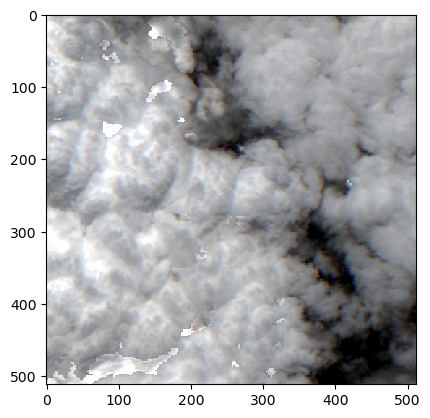

In [37]:
import glob
import rasterio

from common.utilities.visualization import plot_bands

files = glob.glob('./data/radiantEarth/clouds/train/source/*.tif')

print(len(files))
for fp in files[:50]:
    with rasterio.open(fp) as src:
        data = src.read(masked=True)
        print(np.min(data), np.ma.median(data), np.max(data))
        
        if np.ma.median(data) > 0.6:
            plot_bands(data, bands=[2, 1, 0], transpose=True)
            raise



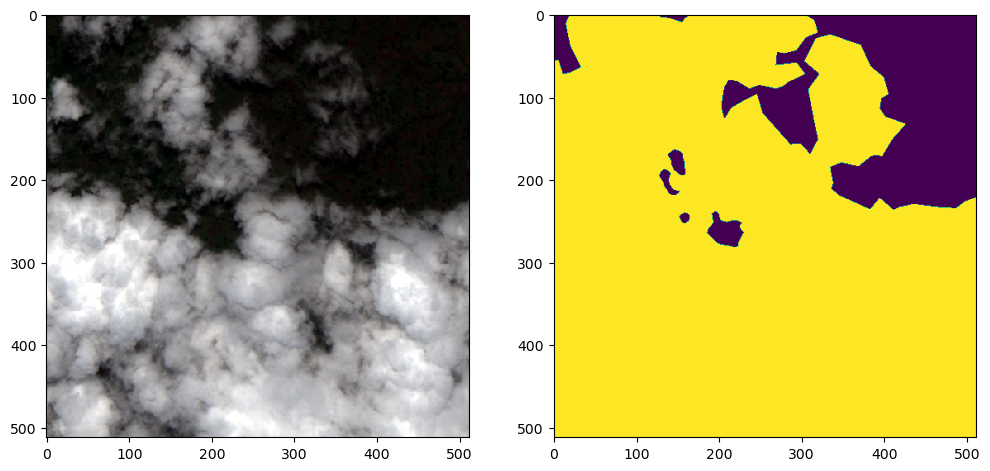

In [31]:
import matplotlib.pyplot as plt
import rasterio

from common.utilities.visualization import plot_bands

chip_id = "cxoz_90deg"

with rasterio.open(f'./data/radiantEarth/clouds/test/source/{chip_id}.tif') as src:
    source = src.read()

with rasterio.open(f'./data/radiantEarth/clouds/test/labels/{chip_id}.tif') as src:
    labels = src.read(1)    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
plot_bands(source, bands=[2, 1, 0], ax=ax1, transpose=True)
ax2.imshow(labels)
plt.show()


In [11]:
%%bash

gdalinfo ./data/radiantEarth/clouds/train/labels/xeak.tif

Driver: GTiff/GeoTIFF
Files: ./data/radiantEarth/clouds/train/source/xeak.tif
Size is 512, 512
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 21N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 21N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-57,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
          